# Cost design wrt actions

This notebook attempts to properly design the proximity cost function for the controlled agent.

$$
C_x(x) = a\big[x_s(v_0) - l/2 - x\big]^p
$$

where

- $l$: vehicle length, *e.g.* equal to $4.8\,\text{m}$;
- $w$: vehicle width, *e.g.* equal to $1.8\,\text{m}$;
- $x_s(v_0)$: safety distance in the $x$ direction, $x_s(v_0) = \beta v_0 + {l \over 2} + 1\,\text{m}$, $\beta = 1.5$;

Let's also enforce $[x] = \mathrm{m}$.

In [13]:
from matplotlib.pylab import *

In [172]:
style.use(['dark_background', 'bmh'])
rc('axes', facecolor='none')
rc('figure', figsize=(12, 3))
rc('savefig', bbox='tight')

In [24]:
from astropy import units as u
U = u.Unit

In [79]:
l = 4.8 * u.m
w = 1.8 * u.m
print(f'car length: {l}')
print(f'car width: {w}')

car length: 4.8 m
car width: 1.8 m


In [45]:
lane = 3.7 * u.m
print(f'US lane width: {lane}')

US lane width: 3.7 m


In [222]:
v0 = (30 * U('km/h')).si
print(f"speed: {v0.to('km/h'):.1f}")

β = 1.5 * u.s
x_s = β * v0 + l/2 + 1 * u.m
print(f'x safety distance: {x_s}')

y_d = lane - 2 * (w / 2)
print(f'y decay distance: {y_d:.1f}')

speed: 30.0 km / h
x safety distance: 15.9 m
y decay distance: 1.9 m


In [47]:
v_max = 130 * U('km/h')
print(f'max speed: {v_max}')

x_max = (v_max * u.s).si
print(f'max lookahead: {x_max:.1f}')

max speed: 130.0 km / h
max lookahead: 36.1 m


In [92]:
y_max = 2 * lane
print(f'max look sideways: {y_max}')

max look sideways: 7.4 m


In [119]:
δ = 0.1 * u.m
x = arange(-x_max.value, x_max.value, δ.value) * u.m
y = arange(-y_max.value, y_max.value, δ.value) * u.m

Let's consider the poisitive (frontal) side only.
We want a line going through $(x_0, y_0)$, hence $y^+ - y_0 = m (x^+ - x_0)$.
Moreover, we want the slope to be $m = y_1 - y_0 \big/ x_1 - x_0$.
Therefore, we end up with the following equality:

$$
y^+ - y_0 = {y_1 - y_0 \over x_1 - x_0}(x^+ - x_0)
$$

Finally, given that $(x_0, y_0) = (x_s, 0)$ and $(x_1, y_1) = \big({l\over2}, 1\big)$ we get that:

$$
\begin{aligned}
y^+ = {x^+ - x_s \over {l\over2} - x_s} &= - {x^+ - x_s \over x_s - {l\over2}} \\ 
y^- &= + {x^- - x_s \over x_s - {l\over2}}
\end{aligned}
$$

Putting altogether, we get:

$$
y = - {\vert x \vert - x_s \over x_s - {l\over2}}
$$

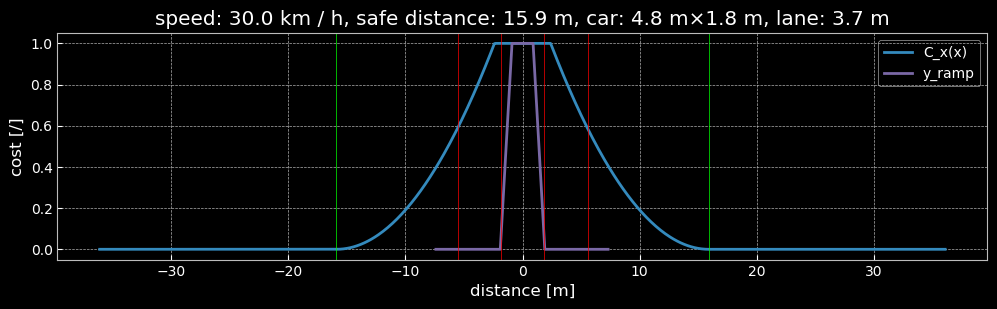

In [223]:
p = 2  # polynomial degree
C_xx = minimum(maximum(-(abs(x) - x_s)/(x_s - l/2), 0), 1)**p
r_y = minimum(maximum(-(abs(y) - y_d)/(y_d - w/2), 0), 1)


plot(x, C_xx, c='C0', label='C_x(x)')
plot(y, r_y, c='C2', label='y_ramp')
xlabel('distance [m]')
ylabel('cost [/]')
legend();
for m in arange(-1.5, 2, 1):
    axvline(m * lane.value, lw=0.5, c=(1,0,0))
axvline(-x_s.value, lw=0.5, c=(0,1,0))
axvline(+x_s.value, lw=0.5, c=(0,1,0))

title(f'speed: {v0.to("km/h")}, safe distance: {x_s}, car: {l}×{w}, lane: {lane}')
savefig('x-cost.png', dpi=300)

In [224]:
C_x = C_xx.reshape(-1, 1) @ r_y.reshape(1, -1)

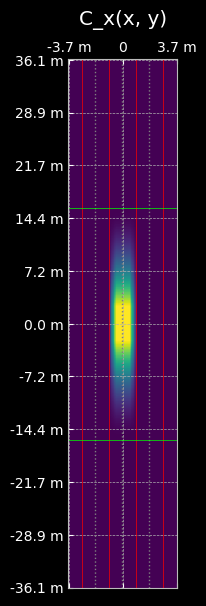

In [225]:
f, a = subplots(figsize=(1.4, 7), dpi=100)
a.matshow(C_x, origin='lower')
axis('equal')
title('C_x(x, y)')
H, W = C_x.shape
xticks(linspace(0, W-1, 3), [str(-lane), '0', str(lane)])
yticks(linspace(0, H-1, 11), [f'{n:.1f}' for n in linspace(-x_max, x_max, 11)]);
# add some references
for m in arange(-1.5, 2, 1):
    axvline(W/2 - 1 + m * lane / δ, lw=.5, c=(1,0,0))
for m in arange(-1, 2, 1):
    axvline(W/2 - 1 + m * lane / δ, lw=1, c='.5', ls=':')
axhline(H/2 - 1 + x_s / δ, lw=.5, c=(0,1,0))
axhline(H/2 - 1 - x_s / δ, lw=.5, c=(0,1,0))
savefig('x-map.png', dpi=300)